### Criação da aeronave

In [5]:
import numpy as np
from numpy import radians
import matplotlib.pyplot as plt
tempo_simulacao = 500

In [6]:
# Creates vehicle and set values
from pyaat.aircraft import Aircraft
minhaAeronave = Aircraft(mass=45e3, Ixx=0.554e6, Iyy=2.53e6,
                         Izz =3.01e6, Izx=0.106e6, Cbarw =3.666,
                         bw=28.42, Sw=95.0)


# Aerodynamic coeficients
minhaAeronave.coef0 = [0.0252, 0.0, 0.382, 0.0, 0.0622, 0.0]
minhaAeronave.coefALPHA = [0.2010, 0.0, 6.29, 0.0, -3.63, 0.0]
minhaAeronave.coefBETA = [0.0, 0.785, 0.0, -0.121, 0.0, 0.174]
minhaAeronave.coefP = [0.0, -0.0794, 0.0, -0.522, 0.0, -0.0587]
minhaAeronave.coefQ = [0.281, 0.0, 14.6, 0.0, -45.5, 0.0]
minhaAeronave.coefR = [0.0, 0.572, 0.0, 0.254, 0.0, -0.277]

minhaAeronave.CLmax = 2.4
minhaAeronave.qmax = 23052.05 # considering 700km/h at sea level
minhaAeronave.Vinf = 200

# Environment

minhaAeronave.set_control_surface('Profundor', [0.0126, 0.0, 0.3891, 0.0, -1.5980, 0.0],(radians(-30), radians(30)))
minhaAeronave.set_control_surface('Aileron', [0.0, 0.0094, 0.0, -0.1784, 0.0, 0.0080],(radians(-20), radians(30)))
minhaAeronave.set_control_surface('Leme', [0.0, -0.3030, 0.0, -0.0464, 0.0, -0.1594],(radians(-40), radians(40)))

from pyaat.atmosphere import atmosISA
minhaAtmosfera = atmosISA()

from pyaat.gravity import Earth_NewtonGravity
minhaGravidade = Earth_NewtonGravity()

from pyaat.propulsion import JetModel
MotorEsquerdo = JetModel('Motor esquerdo', Fmaxi = 35e3, nrho = 0.775, rhoi = 0.41271,
                         Vi = 200.0, nv = 0)
MotorEsquerdo.position = np.array([0, -5, 1.42])
MotorEsquerdo.attitude = np.array([0., radians(0.), 0.])

MotorDireito = JetModel('Motor direito', Fmaxi = 35e3, nrho = 0.775, rhoi = 0.41271,
                         Vi = 200.0, nv = 0)
MotorDireito.position = np.array([0, 5.0, 1.42])
MotorDireito.attitude = np.array([0., radians(0.), 0.])

minhaPropulsao = [MotorEsquerdo, MotorDireito]

from pyaat.system import system
meuSistema = system(atmosphere = minhaAtmosfera,
                    propulsion = minhaPropulsao,
                    aircraft = minhaAeronave,
                    gravity = minhaGravidade)

### Cálculo do balanço

In [7]:
Xe, Ue = meuSistema.trimmer(condition = 'climb', zo = -10000, u =224.6, zod = -5)

In [8]:
Xe[7] = Xe[7] + np.radians(0.5)

### Simulação perturbada

In [9]:
#from wind import gust
import copy

#rajada = gust(MaxSpeed = 5, xo = 500, xf = 1000, yo = -1000, yf = 1000)
#rajada2 = gust(MaxSpeed = -5, xo = 2000, xf = 2500, yo = -1000, yf = 1000)
meusVentos = []

from pyaat.pyaatcontrol import doublet
Perturbacao_controle = doublet('Profundor', amplitude = np.radians(3.), t_init =  40, T = 4)
openloopcontrols = []

### Inclui Sensores e atuadores

In [10]:
from pyaat.pyaatcontrol import actuator
act2 = actuator(name = 'ss profundor', command = 'Profundor', tau = 0.2)
actuatorsAndFilters = [act2]

In [11]:
meuSistema = system(atmosphere = minhaAtmosfera,
                    propulsion = minhaPropulsao,
                    aircraft = minhaAeronave,
                    gravity = minhaGravidade,
                    wind = meusVentos,
                    extraDynamics = actuatorsAndFilters)

In [12]:
meuSistemaN = system(atmosphere = minhaAtmosfera,
                    propulsion = minhaPropulsao,
                    aircraft = minhaAeronave,
                    gravity = minhaGravidade)

In [13]:
solution, controls = meuSistemaN.simulate(Xe, Ue, T0 = 0.0,
                                          TF = tempo_simulacao,
                                          state ={'theta':np.radians(-0.5)})
tempo = meuSistema.time

In [14]:
meuSistema.statesNames

['xo',
 'yo',
 'zo',
 'u',
 'v',
 'w',
 'phi',
 'theta',
 'psi',
 'p',
 'q',
 'r',
 'ss profundor']

In [15]:
Xe[7] = Xe[7] + np.radians(0.5)
solution1, controls1 = meuSistema.simulate(Xe, Ue, TF = tempo_simulacao,
                                           control = openloopcontrols,
                                           state ={'theta':np.radians(-0.5)})
tempo1  = meuSistema.time

### Inclui controladores

In [16]:
from pyaat.pyaatcontrol import P, loop, PI

PI_theta = PI(name = 'PI theta', Kp = 1, zero = -0.1)
Ptheta = P(name = 'Ptheta', gain = 2.9)
loop_theta = loop(name ='loop cruize', Xmeasure = 'theta', Xreference = 'theta', command = 'Profundor')
loop_theta.loopControls = [PI_theta, Ptheta]

Pq = P(name = 'Pq', gain = 0.4)
loop_q = loop(name ='loop cruize', Xmeasure = 'q', Xreference = 'q', command = 'Profundor')
loop_q.loopControls = [Pq]

closedloopcontrols = [loop_theta, loop_q]

meuSistema2 = system(atmosphere = minhaAtmosfera,
                    propulsion = minhaPropulsao,
                    aircraft = minhaAeronave,
                    gravity = minhaGravidade,
                    wind = meusVentos,
                    extraDynamics = actuatorsAndFilters,
                    control = closedloopcontrols)

In [17]:
print(meuSistema2.statesNames)

['xo', 'yo', 'zo', 'u', 'v', 'w', 'phi', 'theta', 'psi', 'p', 'q', 'r', 'ss profundor', 'PI theta']


In [18]:
Xe[7] = Xe[7] + np.radians(0.5)
solution2, controls2 = meuSistema2.simulate(Xe, Ue, TF = tempo_simulacao,
                                            control = openloopcontrols,
                                           state ={'theta':np.radians(-0.5)})
tempo2  = meuSistema2.time

In [19]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,6))
# ax[0].plot(tempo2, np.around(meuSistema2.windval[:,0], decimals=4), label = r'SAS Ligado', color = 'k', linestyle = '-')
# ax[0].set_ylabel(r'vento em x')
# ax[0].grid()

# ax[1].plot(tempo2, np.around(meuSistema2.windval[:,1], decimals=4), label = r'SAS Ligado', color = 'k', linestyle = '-')
# ax[1].set_ylabel(r'vento em y')
# ax[1].grid()

# ax[2].plot(tempo2, np.around(meuSistema2.windval[:,2], decimals=4), label = r'SAS Ligado', color = 'k', linestyle = '-')
# ax[2].set_ylabel(r'vento em z')
# ax[2].set_xlabel(r'tempo $[s]$')
# ax[2].grid()
# #plt.savefig('vento.pdf', dpi = 400, bbox_inches='tight')


# plt.figure(figsize=(8,2))
# plt.plot(solution1[:,0], np.around(meuSistema2.windval[:,2], decimals=4), label = r'SAS Ligado', color = 'k', linestyle = '-')
# plt.ylabel(r'Vento em $z_o$ [m/s]')
# plt.xlabel(r'Posição $x_o$ [m]')
# plt.grid()
# plt.savefig('vento.pdf', dpi = 400, bbox_inches='tight')

### Plot ângulos

In [20]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,6))
# ax[0].plot(tempo1, np.around(np.degrees(solution1[:,6]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[0].plot(tempo2, np.around(np.degrees(solution2[:,6]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[0].set_ylabel(r'$\phi~ [^o]$')
# ax[0].legend()
# ax[0].grid()

# ax[1].plot(tempo1, np.around(np.degrees(solution1[:,7]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[1].plot(tempo2, np.around(np.degrees(solution2[:,7]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# #ax[1].plot(tempo2, np.around(np.degrees(solution[:,7]), decimals=4), label = r'Referência', color = 'k', linestyle = ':')
# ax[1].set_ylabel(r' $\theta~ [^o]$')
# ax[1].grid()

# ax[2].plot(tempo1, np.around(np.degrees(solution1[:,8]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[2].plot(tempo2, np.around(np.degrees(solution2[:,8]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[2].set_ylabel(r' $\psi~ [^o]$')
# ax[2].set_xlabel(r'tempo $[s]$')
# ax[2].grid()
# #plt.savefig('angulo_cruize.pdf', dpi = 400, bbox_inches='tight')

Text(0.5, 0, 'tempo $[s]$')

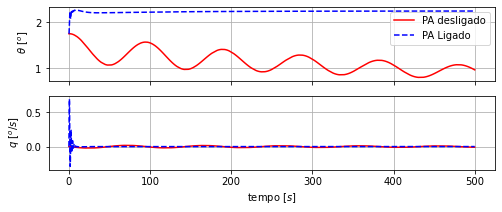

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,3))
ax[0].plot(tempo1, np.around(np.degrees(solution1[:,7]), decimals=4), color = 'r', linestyle = '-', label = r'PA desligado')
ax[0].plot(tempo2, np.around(np.degrees(solution2[:,7]), decimals=4), label = r'PA Ligado', color = 'b', linestyle = '--')
ax[0].set_ylabel(r' $\theta~ [^o]$')
ax[0].legend(loc = 'upper right')
ax[0].grid()

ax[1].plot(tempo1, np.around(np.degrees(solution1[:,10]), decimals=4), color = 'r', linestyle = '-', label = r'PA desligado')
ax[1].plot(tempo2, np.around(np.degrees(solution2[:,10]), decimals=4), label = r'PA Ligado', color = 'b', linestyle = '--')
ax[1].set_ylabel(r' $q~ [^o/s]$')
ax[1].grid()
ax[1].set_xlabel(r'tempo $[s]$')
#plt.savefig('Variaveis_angulares_PA.pdf', dpi = 400, bbox_inches='tight')

### Velocidade ângular

In [22]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,6))
# ax[0].plot(tempo1, np.around(np.degrees(solution1[:,9]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[0].plot(tempo2, np.around(np.degrees(solution2[:,9]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[0].set_ylabel(r'$p~ [^o/s]$')
# ax[0].legend(loc = 'upper right')
# ax[0].grid()

# ax[1].plot(tempo1, np.around(np.degrees(solution1[:,10]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[1].plot(tempo2, np.around(np.degrees(solution2[:,10]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[1].set_ylabel(r' $q~ [^o/s]$')
# ax[1].grid()

# ax[2].plot(tempo1, np.around(np.degrees(solution1[:,11]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[2].plot(tempo2, np.around(np.degrees(solution2[:,11]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[2].set_ylabel(r' $r~ [^o/s]$')
# ax[2].set_xlabel(r'tempo $[s]$')
# ax[2].grid()
# #plt.savefig('angulo_speed_cruize.pdf', dpi = 400, bbox_inches='tight')

### Velocidades lineares

In [23]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,6))
# ax[0].plot(tempo1, np.around((solution1[:,3]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[0].plot(tempo2, np.around((solution2[:,3]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[0].set_ylabel(r'$u$ [m/s]')
# ax[0].legend()
# ax[0].grid()

# ax[1].plot(tempo1, np.around((solution1[:,4]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[1].plot(tempo2, np.around((solution2[:,4]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[1].set_ylabel(r' $v$ [m/s]')
# ax[1].grid()

# ax[2].plot(tempo1, np.around((solution1[:,5]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[2].plot(tempo2, np.around((solution2[:,5]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[2].set_ylabel(r' $w$ [m/s]')
# ax[2].set_xlabel(r'tempo $[s]$')
# ax[2].grid()
# #plt.savefig('velocidade_cruize.pdf', dpi = 400, bbox_inches='tight')

In [24]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,4))
# ax[0].plot(tempo1, np.around((solution1[:,3]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[0].plot(tempo2, np.around((solution2[:,3]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[0].set_ylabel(r'$u$ [m/s]')
# ax[0].set_xlabel(r'tempo $[s]$')
# ax[0].legend()
# ax[0].grid()

# ax[1].plot(tempo1, np.around((solution1[:,5]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[1].plot(tempo2, np.around((solution2[:,5]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[1].set_ylabel(r' $w$ [m/s]')
# ax[1].set_xlabel(r'tempo $[s]$')
# ax[1].grid()
# plt.savefig('velocidades_com_SAS.pdf', dpi = 400, bbox_inches='tight')

### Posição

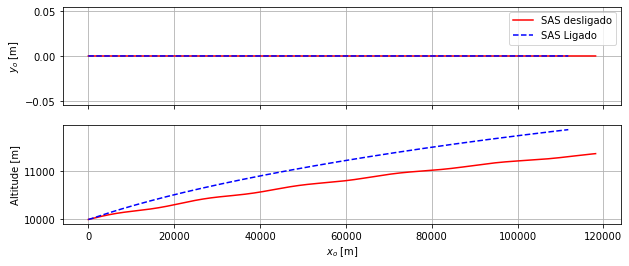

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,4))
ax[0].plot(np.around(solution1[:,0], decimals=4), np.around(solution1[:,1], decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[0].plot(np.around(solution2[:,0], decimals=4), np.around(solution2[:,1], decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[0].set_ylabel(r'$y_o$ [m]')
ax[0].legend()
ax[0].grid()

ax[1].plot(np.around(solution1[:,0], decimals=4), np.around(-solution1[:,2], decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[1].plot(np.around(solution2[:,0], decimals=4), np.around(-solution2[:,2], decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[1].set_ylabel(r'Altitude [m]')
ax[1].set_xlabel(r'$x_o$ [m]')
ax[1].grid()
#plt.savefig('Posicao_SAS.pdf', dpi = 400, bbox_inches='tight')

### Controles

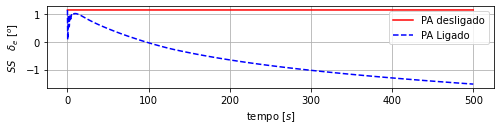

In [26]:
# fig, ax = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(10,8))
# ax[0].plot(tempo1, np.around(np.degrees(controls1[0,:]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[0].plot(tempo2, np.around(np.degrees(controls2[0,:]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[0].set_ylabel(r'$\delta_e$ $[^o]$')
# ax[0].grid()

# ax[1].plot(tempo1, np.around(np.degrees(controls1[1,:]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[1].plot(tempo2, np.around(np.degrees(controls2[1,:]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[1].set_ylabel(r'$\delta_a$ $[^o]$')
# ax[1].grid()

# ax[2].plot(tempo1, np.around(np.degrees(controls1[2,:]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[2].plot(tempo2, np.around(np.degrees(controls2[2,:]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[2].set_ylabel(r'$\delta_r$ $[^o]$')
# ax[2].grid()

# ax[3].plot(tempo1, np.around((controls1[3,:])*100, decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[3].plot(tempo2, np.around((controls2[3,:])*100, decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[0].legend(loc = 'upper right')
# ax[3].set_ylabel(r'$\delta_{pe}$ $[\%]$')
# ax[3].grid()

# ax[4].plot(tempo1, np.around((controls1[6,:])*100, decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[4].plot(tempo2, np.around((controls2[6,:])*100, decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[4].set_ylabel(r'$\delta_{pd}$ $[\%]$')
# ax[4].set_xlabel(r'tempo $[s]$')
# ax[4].grid()
#plt.savefig('controles_cruise.pdf', dpi = 400, bbox_inches='tight')


plt.figure(figsize=(8,1.5))
plt.plot(tempo1, np.around(np.degrees(solution1[:,12]), decimals=4), color = 'r', linestyle = '-', label = r'PA desligado')
plt.plot(tempo2, np.around(np.degrees(solution2[:,12]), decimals=4), label = r'PA Ligado', color = 'b', linestyle = '--')
plt.ylabel(r'$SS \ ~\ \delta_e$ $[^o]$')
plt.xlabel(r'tempo $[s]$')
plt.legend(loc = 'upper right')
plt.grid()
#plt.savefig('Profundor_PA.pdf', dpi = 400, bbox_inches='tight')

In [27]:
meuSistema2.statesNames

['xo',
 'yo',
 'zo',
 'u',
 'v',
 'w',
 'phi',
 'theta',
 'psi',
 'p',
 'q',
 'r',
 'ss profundor',
 'PI theta']

In [28]:
# plt.figure(figsize=(8,2))
# plt.plot(tempo2, np.around(np.degrees(solution2[:,14]), decimals=4), label = r'Avanco', color = 'b', linestyle = '--')
# plt.ylabel(r'saida$[^o]$')
# plt.xlabel(r'tempo $[s]$')
# plt.legend(loc = 'upper right')
# plt.grid()

# plt.figure(figsize=(8,2))
# plt.plot(tempo2, np.around(np.degrees(solution2[:,15]), decimals=4), label = r'integrador', color = 'b', linestyle = '--')
# plt.ylabel(r'int. erro$[^o]$')
# plt.xlabel(r'tempo $[s]$')
# plt.legend(loc = 'upper right')
# plt.grid()

In [29]:
#import matplotlib.pyplot as plt
#fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,6))
#ax[0].plot(tempo2, np.around(solution2[:,14], decimals=4), label = r'w com filtro', color = 'b', linestyle = '--')
#ax[0].plot(tempo2, np.around((solution2[:,13]), decimals=4), label = r'w do barramento', color = 'r', linestyle = '-')
#ax[0].plot(tempo2, np.around((solution2[:,5]), decimals=4), label = r'w real', color = 'g', linestyle = '-')
#ax[0].set_ylabel(r'$P1$')
#ax[0].legend('upper left')
#ax[0].legend(loc = 'upper right')
#ax[0].grid()

#ax[1].plot(tempo2, np.around(np.degrees(solution2[:,15]), decimals=4), color = 'b', linestyle = '--')
#ax[1].set_ylabel(r' $P2$')
#ax[1].grid()

#ax[2].plot(tempo2, np.around(np.degrees(solution2[:,16]), decimals=4), color = 'b', linestyle = '--')
#ax[2].set_ylabel(r' $P3$')
#ax[2].set_xlabel(r'tempo $[s]$')
#ax[2].grid()
#plt.savefig('angulo_speed_cruize.pdf', dpi = 400, bbox_inches='tight')

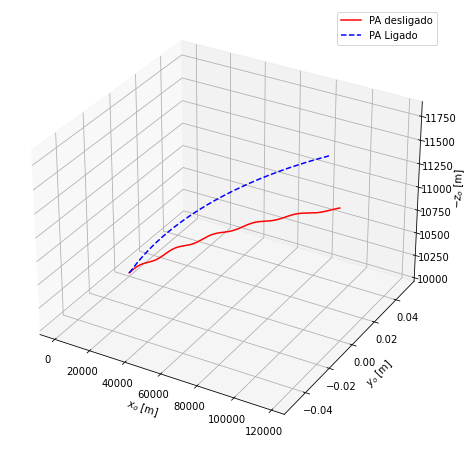

In [30]:
fig = plt.figure(figsize = [8,8])
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(np.around(solution1[:,0], decimals=4),
          np.around(solution1[:,1], decimals=4),
          np.around(-solution1[:,2], decimals=4),
          color = 'r', linestyle = '-', label = r'PA desligado')

ax.plot3D(np.around(solution2[:,0], decimals=4),
          np.around(solution2[:,1], decimals=4),
          np.around(-solution2[:,2], decimals=4),
          label = r'PA Ligado', color = 'b', linestyle = '--')
ax.set_xlabel('$x_o$ [m]')
ax.set_ylabel('$y_o$ [m]')
ax.set_zlabel('$-z_o$ [m]')
ax.legend()
#plt.savefig('3d_PA_theta.pdf', dpi = 400, bbox_inches='tight')